In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import numpy.random as rndm

In [2]:
def convolve(u, filter_size=50):
    t = np.linspace(-10, 10, filter_size)
    bump = np.exp(-0.1*t**2)
    bump /= np.trapz(bump) # normalize the integral to 1
    # make a 2-D kernel out of it
    kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
    # mode='same' is there to enforce the same output shape as input arrays
    img3 = signal.fftconvolve(u, kernel, mode='same')
    return(img3)

In [3]:
def partialDerivs(E, E1):
    # Calculates the partial derivatives of the given list of frames
    M, N = frames[0].shape
    X = np.zeros((M,N))
    Y = np.zeros((M,N))
    T = np.zeros((M,N))
    for i in range(M-1):
        for j in range(N-1):
            Ex = ( E[i,j+1]    - E[i,j]
                  + E[i+1,j+1]  - E[i+1,j]
                  + E1[i,j+1]   - E1[i,j]
                  + E1[i+1,j+1] - E1[i+1,j] )*(1/4)
            Ey = ( E[i+1,j]    - E[i,j]
                  + E[i+1,j+1]  - E[i,j+1]
                  + E1[i+1,j]   - E1[i,j]
                  + E1[i+1,j+1] - E1[i,j+1] )*(1/4)
            Et = ( E1[i,j]     - E[i,j]
                  + E1[i+1,j]   - E[i+1,j]
                  + E1[i,j+1]   - E[i,j+1]
                  + E1[i+1,j+1] - E[i+1,j+1] )*(1/4)
            X[i,j] = Ex
            Y[i,j] = Ey
            T[i,j] = Et
    return(X, Y, T)

In [4]:
def calculateBars(matrix):
    # Returns the weighted averages described in the paper given a matrix
    M, N = matrix.shape
    Ubar = np.zeros((M,N))
    for x in range(1,M-1):
        for y in range(1,N-1):
            Ubar[x,y] = ( 1/12*(matrix[x-1,y-1] + matrix[x+1,y-1] + matrix[x-1,y+1] + matrix[x+1,y+1])
                        + 1/6*(matrix[x-1,y] + matrix[x,y-1] + matrix[x+1,y] + matrix[x,y+1]) - matrix[x,y] )
    return(Ubar)

In [5]:
def nextIteration(U, V, Ubar, Vbar, Ex, Ey, Et, alpha, lr):
    # Returns the next iteration when given the matrices for U, V, and partial derivatives
    # This is to be run on simply one frame
    M,N = U.shape
    new_U, new_V = np.zeros((M,N)), np.zeros((M,N))
    numerator_U = Ex*(Ex*Ubar + Ey*Vbar + Et)
    numerator_V = Ey*(Ex*Ubar + Ey*Vbar + Et)
    denom = 4*(alpha**2) + Ex**2 + Ey**2
    new_U = U - lr*(numerator_U/denom)
    new_V = V - lr*(numerator_V/denom)
    return(new_U, new_V)

In [16]:
def estimateFlowVectors(frame0, frame1, N_iter, alpha, lr):
    M,N = frame0.shape
    Ex, Ey, Et = partialDerivs(frame0, frame1)
    U, V = np.zeros((M,N)), np.zeros((M,N))
    for k in range(N_iter):
        if k%10 == 0:
            print(k)
        Ubar, Vbar = calculateBars(U), calculateBars(V)
        U, V = nextIteration(U, V, Ubar, Vbar, Ex, Ey, Et, alpha, lr)
    return(U, V)

In [11]:
def readFrames(folderpath):
    filenames = os.listdir(folderpath)
    frames = []
    for FILE in filenames:
        if FILE[-3:] == 'png':
            filepath = folderpath + '/' + FILE
            img = np.array( Image.open(filepath).convert('L') , dtype='int64')
            frames.append(img)
    return(frames)

In [7]:
def get_magnitude(u, v, grid):
    scale = 3
    sum = 0.0
    counter = 0.0

    for i in range(0, u.shape[0], grid):
        for j in range(0, u.shape[1], grid):
            counter += 1
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            sum += magnitude

    mag_avg = sum / counter

    return mag_avg

In [27]:
def draw_quiver(u,v,beforeImg, grid):
    scale = 1
    ax = plt.figure().gca()
    ax.imshow(beforeImg, cmap = 'gray')

    magnitudeAvg = get_magnitude(u, v, grid)

    for i in range(1, u.shape[0]-1, grid):
        for j in range(1, u.shape[1]-1, grid):
            dy = v[i,j] * scale
            dx = u[i,j] * scale
            magnitude = (dx**2 + dy**2)**0.5
            #draw only significant changes
            if magnitude > magnitudeAvg:
                ax.arrow(j,i, dx, dy, color = 'red', head_width=4)

    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    plt.draw()
    plt.show()

In [9]:
def add_noise(u, mu, sigma):
    n = rndm.normal(loc=mu, scale=sigma, size = (u.shape))
    noisy = u + n
    return(noisy)

In [19]:
frames = list(reversed(readFrames('dumptruck')))

# Plot the images
#fig, axs = plt.subplots(2,2)
#axs[0,0].imshow(frames[0],cmap='gray')
#axs[0,0].set_title('Frame 0')
#axs[0,0].grid()

#axs[0,1].imshow(frames[1], cmap='gray')
#axs[0,1].set_title('Frame 1')
#axs[0,1].grid()

#axs[1,0].imshow(frames[1]-frames[0],cmap='gray')
#axs[1,0].set_title('Frame 0')
#axs[1,0].set_xticks([])
#axs[1,0].set_yticks([])

In [22]:
L = len(frames)
mu = 0
sigma = 3
lr = 0.01
N_iter = 128
alpha = 1
grid = 4
Fsize = 3

for i in range(L-1):
    print("i= ",i)
    frame0 = convolve(add_noise(frames[i], mu, sigma), filter_size=Fsize)/255
    frame1 = convolve(add_noise(frames[i+1], mu, sigma), filter_size=Fsize)/255

    U1, V1 = estimateFlowVectors(frame0, frame1, N_iter, alpha, lr)

i=  0
0
10
20
30
40
50
60
70
80
90
100
110
120


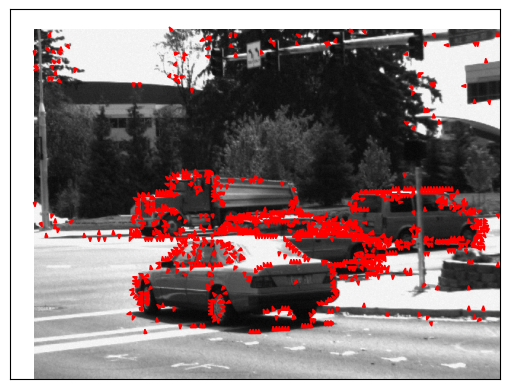

In [28]:
draw_quiver(U1, V1, frame0, grid)

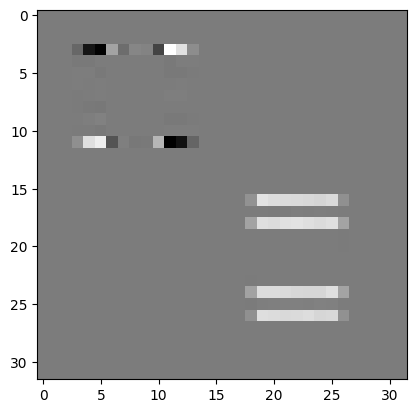

In [ ]:
plt.imshow(V1, cmap='gray')

In [ ]:
# Para los cuadrados

L = len(frames)
mu = 0
sigma = 3
lr = 0.001
N_iter = 32
alpha = 1
grid = 2
Fsize = 3

for i in range(L-1):
    frame0 = convolve(add_noise(frames[i], mu, sigma), filter_size=Fsize)/255
    frame1 = convolve(add_noise(frames[i+1], mu, sigma), filter_size=Fsize)/255

    U1, V1 = estimateFlowVectors(frame0, frame1, N_iter, alpha, lr)

    M,N = frame0.shape

draw_quiver(U1, V1, frame0, grid)